In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import mdtraj
import deep_boltzmann
from deep_boltzmann.networks.training import MLTrainer, FlexibleTrainer
from deep_boltzmann.networks.invertible import invnet, EnergyInvNet, InvNet
from deep_boltzmann.openmmutils import save_latent_samples_as_trajectory
from deep_boltzmann.models.openmm import OpenMMEnergy
import mdtraj as md
from simtk import openmm, unit

import sys, os, shutil
import tensorflow as tf

In [2]:
from IPython import display
display.set_matplotlib_formats("svg")

In [3]:
print("Tensorflow Version:", tf.__version__)

Tensorflow Version: 2.5.0


In [4]:
pdb_model = mdtraj.load_pdb('pdz3_rat_apo_fixed.pdb')

In [5]:
traj = mdtraj.load("traj.h5")
sim_x = traj.xyz
print(sim_x.shape)

(100000, 1655, 3)


In [6]:
def setup_protein(pdbmodel_dir):
    """ Sets up protein Topology and Energy Model

    Returns
    -------
    top : mdtraj Topology object
        Protein topology
    energy : Energy object
        Energy model

    """
    # 4C in KIW's experiment
    INTEGRATOR_ARGS = (277*unit.kelvin, 1.0/unit.picoseconds, 2.0*unit.femtoseconds)

    from simtk.openmm import app
    pdb = app.PDBFile(pdbmodel_dir)
    forcefield = openmm.app.ForceField('amber14/protein.ff14SB.xml', 'amber14/tip3p.xml')

    system = forcefield.createSystem(pdb.topology,removeCMMotion=False,
                                     nonbondedMethod=app.CutoffNonPeriodic, nonbondedCutoff=1.0*unit.nanometers,
                                     constraints=None, rigidWater=True)
    integrator = openmm.LangevinIntegrator(277*unit.kelvin, 1.0/unit.picoseconds, 2.0*unit.femtoseconds)
    simulation = openmm.app.Simulation(pdb.topology, system, integrator)

    protein_omm_energy = OpenMMEnergy(system,
                                   openmm.LangevinIntegrator,
                                   unit.nanometers,
                                   n_atoms=md.Topology().from_openmm(simulation.topology).n_atoms,
                                   openmm_integrator_args=INTEGRATOR_ARGS)

    mdtraj_topology = md.Topology().from_openmm(pdb.topology)
    return mdtraj_topology, protein_omm_energy

def get_indices(top, cartesian_CYS=True):
    """ Returns Cartesian and IC indices

    Returns
    -------
    cart : array
        Cartesian atom selection
    Z : array
        Z index matrix

    """
    from deep_boltzmann.models.proteins import mdtraj2Z
    cartesian = ['CA', 'C', 'N']
    cart = top.select(' '.join(["name " + s for s in cartesian]))
    if cartesian_CYS:
        Z_, _carts = mdtraj2Z(top,  cartesian="resname CYS and mass>2 and sidechain")
        Z_ = np.array(Z_)
        cart = np.sort(np.concatenate((cart,_carts)))
    else:
        Z_ = np.array(mdtraj2Z(top))
    return cart, Z_

In [7]:
def train_KL(bg, xtrain, epochs, high_energies, w_KLs, std=1.0, samplez_std=None, stage=0, rc_dims=None, rc_func=None, rc_min=None, 
             rc_max=None, w_RC=0., w_L2_angle=0., loss_track=[], file_name="./BG_intermediate_model_saved_TF2_smallewKL.pkl"):
    #trainers_KL_state3 = []
    for current_stage in range(stage, len(epochs)):
        print('-----------------------')
        print(high_energies[current_stage], w_KLs[current_stage])
        sys.stdout.flush()
        flextrainer = FlexibleTrainer(bg, lr=0.0001, batch_size=2000,
                                      high_energy=high_energies[current_stage], max_energy=1e20,
                                      w_KL=w_KLs[current_stage], std=std, w_ML=1, weigh_ML=False, w_RC=w_RC,
                                      rc_func=rc_func, rc_min=np.array(rc_min), rc_max=np.array(rc_max),
                                      w_L2_angle=w_L2_angle, 
                                      rc_dims=rc_dims)
        flextrainer.train(xtrain, epochs=epochs[current_stage], samplez_std=samplez_std)
        #trainers_KL_state3.append(flextrainer)
        loss_track.extend(flextrainer.loss_train)

        # Analyze
        samples_z = np.random.randn(2000, bg.dim)
        samples_x = bg.Tzx.predict(samples_z)
        samples_e = bg.energy_model.energy(samples_x)
        energy_violations = [np.count_nonzero(samples_e > E) for E in high_energies]
        print('Energy violations:')
        for E, V in zip(high_energies, energy_violations):
            print(V, '\t>\t', E)
        sys.stdout.flush()

        # SAVE
        bg.save(file_name)
        saveconfig = {}
        saveconfig['stage'] = current_stage
        #np.savez_compressed('config_save.npz', **saveconfig)
        print('Intermediate result saved')
        sys.stdout.flush()
    return loss_track

### Load the intermediate results after long time ML training

In [8]:
top, mm_pdz = setup_protein('pdz3_rat_apo_fixed.pdb')

In [9]:
bg = EnergyInvNet.load("./BG_save_after_ML_TF2_longerML2.pkl", mm_pdz)

Before connect
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Done xz
Done zx


In [10]:
# Superimpose frames and reshuffle 
nframes = sim_x.shape[0]
dim = sim_x.shape[1]*sim_x.shape[2]
sim_x_traj = mdtraj.Trajectory(sim_x.reshape((nframes, int(dim/3), 3)), top)
sim_x_traj = sim_x_traj.superpose(sim_x_traj[0], atom_indices=top.select('backbone'))
sim_x = sim_x_traj.xyz.reshape((nframes, -1))
np.random.shuffle(sim_x)

In [22]:
saveconfig = {}
# Train KL
saveconfig['stage'] = 0

epochs_KL     = [  15,   15,   15,   15,   15,   15,  20,  20,  30, 50, 50, 300]
high_energies = [1e10,  1e9,  1e8,  1e7,  1e6,  1e5,  1e5,  1e5,  5e4,  5e4,  2e4,  2e4]
w_KLs         = [1e-12, 1e-6, 1e-5, 1e-4, 1e-3, 1e-3, 5e-3, 1e-3, 5e-3, 0.01, 0.01, 0.01]
loss_track = train_KL(bg,  sim_x, epochs_KL, high_energies, w_KLs, stage = saveconfig['stage'],std=2.0, w_L2_angle=1.0, loss_track=[],
                     file_name="BG_intermediate_model_saved_TF2_changeTemperature.pkl")

-----------------------
10000000000.0 1e-12
Epoch 0/15 Overall Loss -3296.6738 ML Loss -21672.7715 KL Loss 3285096960.0000 L2 Angle Loss 18376.0938 
Epoch 1/15 Overall Loss -9954.0850 ML Loss -21655.0078 KL Loss 3285725440.0000 L2 Angle Loss 11700.9180 
Epoch 2/15 Overall Loss -12201.8916 ML Loss -21638.0039 KL Loss 3332711936.0000 L2 Angle Loss 9436.1123 
Epoch 3/15 Overall Loss -16706.4375 ML Loss -21622.0000 KL Loss 3312014080.0000 L2 Angle Loss 4915.5605 
Epoch 4/15 Overall Loss -18382.5508 ML Loss -21601.0039 KL Loss 3286160384.0000 L2 Angle Loss 3218.4495 
Epoch 5/15 Overall Loss -19226.9316 ML Loss -21587.9551 KL Loss 3103008000.0000 L2 Angle Loss 2361.0212 
Epoch 6/15 Overall Loss -20187.2422 ML Loss -21570.5508 KL Loss 3155227648.0000 L2 Angle Loss 1383.3030 
Epoch 7/15 Overall Loss -20480.8262 ML Loss -21561.0176 KL Loss 2977718272.0000 L2 Angle Loss 1080.1858 
Epoch 8/15 Overall Loss -20910.4941 ML Loss -21547.8418 KL Loss 2890476288.0000 L2 Angle Loss 637.3455 
Epoch 9/15 O

KeyboardInterrupt: 

### Visualization

In [25]:
%%time
zsamples, xsamples, zenergys, xenergys, logw = bg.sample(std=2.0, nsample=10000)

CPU times: user 1min 8s, sys: 29.1 s, total: 1min 37s
Wall time: 31.6 s


(0.0, 5000.0)

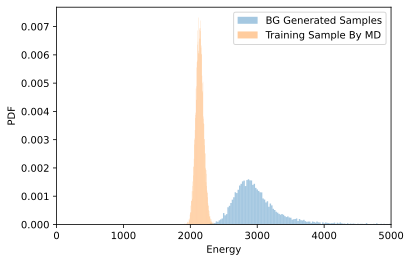

In [34]:
plt.hist(xenergys[xenergys<5000],bins=128,density=True,alpha=0.4, label="BG Generated Samples");
plt.hist(mm_pdz.energy(sim_x[::10,:]), bins=128,density=True,alpha=0.4, label='Training Sample By MD');
plt.xlabel("Energy")
plt.ylabel("PDF")
plt.legend()
plt.xlim(0,5000)

### LEU44 and SER45 CA 

In [27]:
atoms_list = list(traj.top.atoms)
atoms_list = [str(i) for i in atoms_list]
w_ILE44CA = atoms_list.index("LEU44-CA")
w_SER45CA = atoms_list.index("SER45-CA")

In [28]:
MDcoords_ILE44CA = sim_x.reshape((100000, 1655, 3))[:,w_ILE44CA,:]
BGcoords_ILE44CA = xsamples.reshape((10000,1655,3))[:,w_ILE44CA,:]

In [29]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(MDcoords_ILE44CA)

PCA(n_components=2)

In [30]:
rd_index = np.random.choice(100000, 10000, replace=False)
rd_index2 = np.random.choice(10000, 1000, replace=False)

In [31]:
MD44_PC = pca.fit_transform(MDcoords_ILE44CA)
BG44_PC = pca.fit_transform(BGcoords_ILE44CA)

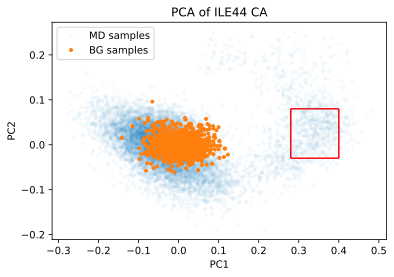

In [32]:
plt.plot(MD44_PC[rd_index,0],MD44_PC[rd_index,1], '.', alpha=0.03, label="MD samples")
plt.plot(BG44_PC[rd_index2,0],BG44_PC[rd_index2,1], '.', alpha=1, label="BG samples")
#plt.plot(BG1p544_PC[rd_index2,0],BG1p544_PC[rd_index2,1], '.', alpha=0.02, label="BG samples, higher temperature")
#plt.plot(BG2044_PC[rd_index2,0],BG2044_PC[rd_index2,1], '.', alpha=0.1, label="BG samples, Even higher")
plt.vlines(0.28, -0.03, 0.08, colors='red')
plt.vlines(0.40, -0.03, 0.08, colors='red')
plt.hlines(-0.03, 0.28, 0.40, colors='red')
plt.hlines(0.08, 0.28, 0.40, colors='red')
plt.title("PCA of ILE44 CA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

In [8]:
bg = EnergyInvNet.load("./BG_intermediate_model_saved_TF2_changeTemperature.pkl", mm_pdz)

Before connect
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Done xz
Done zx


In [13]:
bg.Txz.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4965)]       0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 4959)         0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4965)         0           lambda[0][0]                     
__________________________________________________________________________________________________
index_layer (IndexLayer)        (None, 2480)         0           lambda_1[0][0]                   
______________________________________________________________________________________________

In [14]:
bg.dim

4965